# Use pretrained BERT model for classification

## Would Lasse recommend this book?

This is the second part of the three part blogpost on my NLP project. In this blogpost I will show you how to use a pretrained BERT model to finetune a model to predict how I would rate a book based on one page. In the [first part](https://lschmiddey.github.io/fastpages_/2020/09/22/Teach-Python-how-to-read.html) I showed how to build the dataset. Now I will show you how to use this data to basically build a model from that. First, let's get our packages.

In [ ]:
!pip install transformers
!pip install seaborn

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertTokenizer, BertForSequenceClassification

# specify GPU
device = torch.device("cuda")

We then load the data we got from our images in combination with pytesseract.

# Load Data

In [2]:
p = Path.cwd()

complete_df = pd.read_csv(p/'datasets/text_df.csv')  
complete_df.head()

,text,title,rating
0,war ein schrecklicher Rückfall eingetreten.In ...,gegendenStrich,1
1,"höchst moralischer Akt, die Welt von einem sol...",derSeewolf,5
2,deutsches Luder nehmen. Und sollten Sie es dan...,ButchersCrossing,4
3,müssen.»Sie kamen jetzt in die Vorstadt. Die S...,diePest,2
4,"ins Gesicht, wandte sich von ihrem traurigen A...",diePest,2


We only need the text and my rating. We also need to substract 1 from my rating for indexing purposes for the cross entropy loss function.

In [3]:
df = pd.DataFrame({
    'label': complete_df.iloc[:,2]-1,
    'text': complete_df.iloc[:,0]
})

df.head()

,label,text
0,0,war ein schrecklicher Rückfall eingetreten.In ...
1,4,"höchst moralischer Akt, die Welt von einem sol..."
2,3,deutsches Luder nehmen. Und sollten Sie es dan...
3,1,müssen.»Sie kamen jetzt in die Vorstadt. Die S...
4,1,"ins Gesicht, wandte sich von ihrem traurigen A..."


In [4]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.label.values

## Bert Tokenizer

My data is in German. Luckily, the awesome huggingface library provides a crazy amount of pretrained models in languages from all over the world. We first need our tokenizer:

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-german-cased'

# Load the BERT tokenizer
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', PRE_TRAINED_MODEL_NAME)    # Download vocabulary from S3 and cache.

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Let's look what the tokenizer does to our text sentences:

In [6]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


 Original:  war ein schrecklicher Rückfall eingetreten.In dem »verheirateten Priester« wurde das LobChristi von Barbey d’Aurévilly gesungen; in »LesDiaboliques« hatte sich der Verfasser dem Teufel ergeben, den er pries; und jetzt erschien der Sadismus,dieser Bastard des Katholizismus, den die Religion inallen Formen mit Exorzismen und Scheiterhaufendurch alle Jahrhunderte verfolgt hat.Mit Barbey d’Aurévilly nahm die Serie der reli—giösen Schriftsteller ein Ende. Eigentlich gehörte dieser Paria in jeder Hinsicht mehr zur weltlichen Literatur als zu jener andern, bei der er einen Platzbeanspruchte, den man ihm verweigerte. Seine Sprache war die des wilden Romantismus, voll gewunde—ner Wendungen und übertriebener Vergleiche, undeigentlich erschien d’Aurévilly wie ein Zuchthengstunter diesen Wallachen, die die ultramontanen StalleDem Herzog kamen diese Betrachtungen heimgelegentlichen Wiederlesen einiger Stellen diesesC L (  ii i „ .. ‚]:„„„„ „a.—näepn alwxxr9rl’iﬂ»
Tokenized:  ['war', 'ei

So our bert-base-german-cased tokenizer splits the words into reasonable parts, which correspond to the token ids (input ids).

## Tokenize Dataset

Let's check the length for each sequence and print the max sequence length.

In [7]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  538


Das Maximum sentence length is 538. However, the maximum sentence length allowed by Bert is 512, so we have to set max_len to 256. Next, we tokenize all of our sentences.

In [8]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True,
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        #padding='longest',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)



/opt/conda/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Training and Validation Set

We then put our data into a pytorch dataset and split the data into training and validation set.

In [9]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


   75 training samples
   19 validation samples


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


After putting the dataset into a dataloader we define how many different classes we've got.

In [11]:
n_classes=5

## Get pretrained model

In [12]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = n_classes, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Optimizer and Learning Rate

We use AdamW as our optimizer and use CrossEntropyLoss as our loss function.

In [13]:
from transformers import AdamW

In [14]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-4, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [15]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [16]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Train Model

Let's train our model!

In [18]:
import random
import numpy as np
import time
import datetime

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print(f'Batch:{step} of {len(train_dataloader)}. Elapsed: {elapsed}')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()   
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
               
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        (loss, logits) = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        #total_eval_accuracy += sum((preds-b_labels)^2).cpu().numpy()
        

    # Report the final accuracy for this validation run.
    #avg_val_accuracy = total_eval_accuracy #total_eval_accuracy / len(validation_dataloader)
    #print(f'Accuracy: {avg_val_accuracy}')

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Validation took: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            #'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.52
  Training epoch took: 0:00:07

Running Validation...
Validation Loss: 1.3076387345790863
Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.34
  Training epoch took: 0:00:07

Running Validation...
Validation Loss: 1.1822895407676697
Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.85
  Training epoch took: 0:00:07

Running Validation...
Validation Loss: 0.8835422396659851
Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.32
  Training epoch took: 0:00:07

Running Validation...
Validation Loss: 0.46347731351852417
Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.13
  Training epoch took: 0:00:07

Running Validation...
Validation Loss: 0.4694706201553345
Validation took: 0:00:01

Training complete!
Total training took 0:00:40 (h:mm:

## Evaluation

In [19]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.52,1.31,0:00:07,0:00:01
2,1.34,1.18,0:00:07,0:00:01
3,0.85,0.88,0:00:07,0:00:01
4,0.32,0.46,0:00:07,0:00:01
5,0.13,0.47,0:00:07,0:00:01


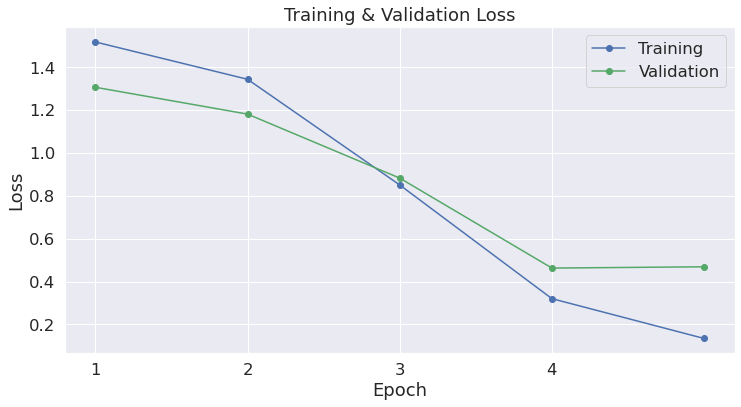

In [20]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


# Look at results

So far, we can see that our model learns. Let's have a look how the predictions on our trainloader look like:

In [21]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in train_dataloader:
    
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        print('    DONE.')


    DONE.
    DONE.
    DONE.
    DONE.
    DONE.


In [22]:
np.argmax(predictions[4], axis=1)

array([0, 4, 4, 0, 4, 3, 3, 3, 4, 3, 4])

In [23]:
true_labels[4]

array([0, 4, 4, 0, 4, 3, 3, 3, 4, 3, 4])

Well that looks right. However, this is the data we trained our model on. Way more interesting is the data our model hasn't trained on:

In [24]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in validation_dataloader:
    
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        print('    DONE.')


    DONE.
    DONE.


In [25]:
np.argmax(predictions[0], axis=1)

array([4, 3, 2, 1, 4, 0, 4, 1, 0, 1, 3, 4, 3, 4, 1, 4])

In [26]:
true_labels[0]

array([3, 3, 1, 1, 4, 0, 0, 1, 0, 1, 3, 4, 3, 4, 1, 4])

Awesome! We have quite some variation in our prediction and most of the time they look pretty good! We save our model:

## Save Model

In [29]:
torch.save(model.state_dict(), p/'model/model_5epochs_lr1e-4.pt')

To further improve the model, I will get more data and then retrain it. However, I think so far the model does a pretty good job in replacing me when it comes to book recómmendations. 

In the next part I will show you how to use Binder to make a small web application in which we can upload a picture of a page and then make a prediction how many stars I would probably give this book.

So stay tuned for the next blogpost!

Lasse